# **Mode collapse**

In [1]:
from google.colab import drive
import sys
drive.mount("/content/gdrive", force_remount=True)
sys.path.append('/content/gdrive/My Drive/THESIS')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from backend.preprocessing import rolling_window
from sklearn.cluster import KMeans

In [3]:
paths = np.array(pickle.load(open( "/content/gdrive/My Drive/THESIS/datasets/paths.p", "rb" ))).squeeze()

In [4]:
df = pd.read_csv('gdrive/My Drive/THESIS/datasets/SP500.csv', usecols=['Date', 'Open', 'Close'], parse_dates=['Date'] )
df = df.sort_values('Date').reset_index(drop=True)

df['Return'] = df['Close']/df['Close'].shift(1)
df['Log Return'] = np.log(df['Return'])

df.head()

,Date,Open,Close,Return,Log Return
0,2009-05-01,873.00,877.52,NaN,NaN
1,2009-05-04,885.58,907.24,1.033868,0.033307
2,2009-05-05,904.86,903.80,0.996208,-0.003799
3,2009-05-06,914.48,919.53,1.017404,0.017255
4,2009-05-07,929.41,907.39,0.986798,-0.013290


In [5]:
real_returns = df[['Log Return']][1:].to_numpy()

In [6]:
synth_returns = np.log(paths[:, 1:]/paths[:, :-1]).T

# Clustering and plotting procedures

In [7]:
def clustering(real_returns, synth_returns, window_length, n_clusters, random_state=0):

    real_samples = rolling_window(real_returns, window_length).T.squeeze()
    # We cluster based on synth samples, so we skip ahead twice the window length
    # to avoid interdependencies of windows
    synth_samples = rolling_window(synth_returns, window_length)[:, ::window_length*2].T.reshape((-1, window_length))

    kmeans = KMeans(n_clusters=30, random_state=random_state)
    kmeans.fit(synth_samples)

    real_bins = kmeans.predict(real_samples)
    synth_bins = kmeans.predict(synth_samples)

    real_freq = np.bincount(real_bins)
    synth_freq = np.bincount(synth_bins)

    total_freq = np.stack([real_freq, synth_freq])
    total_freq = total_freq / total_freq.sum(axis=1, keepdims=True)

    return real_samples, synth_samples, real_bins, synth_bins, total_freq.T

def plot_clustering(synth_samples, synth_bins, total_freq, alpha, bins):
    fig, ax = plt.subplots(figsize=(20,12), nrows=3, ncols=3, sharex=True, sharey=True)

    i = 0
    j = 0
    for bin in bins:
        ax[i, j].plot(np.moveaxis(synth_samples[synth_bins == bin], 0, -1), color='orange', alpha=alpha)
        ax[i, j].set_title('# paths: {}'.format(int((synth_bins == bin).sum())))
        ax[i, j].grid(axis='y', which='major')

        j += 1
        j = j % 3
        if j == 0:
            i += 1

    plt.setp(ax[-1, :], xlabel='days elapsed')
    plt.setp(ax[:, 0], ylabel='daily log return')

    return fig, ax

In [8]:
real_samples, synth_samples, real_bins, synth_bins, total_freq = clustering(real_returns, synth_returns, 16, 30)

# Distribution of clusters

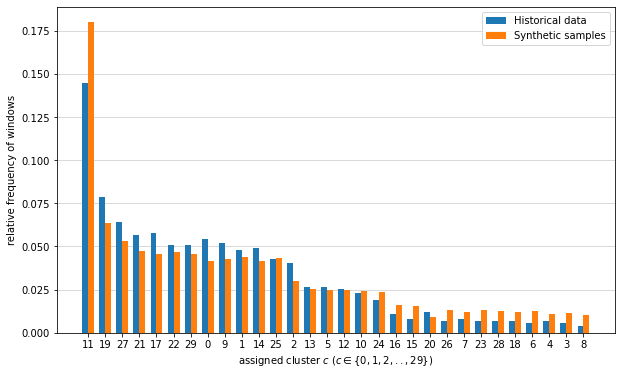

In [9]:
# sort labels by average of frequences
labels = np.argsort(-1*np.sum(total_freq, axis=1))
x = np.arange(len(labels))
y = total_freq[labels]

fig, ax = plt.subplots(figsize=(10,6))

width = 0.35

ax.bar(x - width/2, y[:,0], width)
ax.bar(x + width/2, y[:,1], width)
ax.set_ylabel('relative frequency of windows')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.grid(axis='y', which='major', alpha=.6)
ax.set_axisbelow(True);
ax.legend(['Historical data', 'Synthetic samples'])
ax.set_xlabel('assigned cluster $c$ ($c \in \{0, 1, 2, .., 29\}$)');

# Experiments

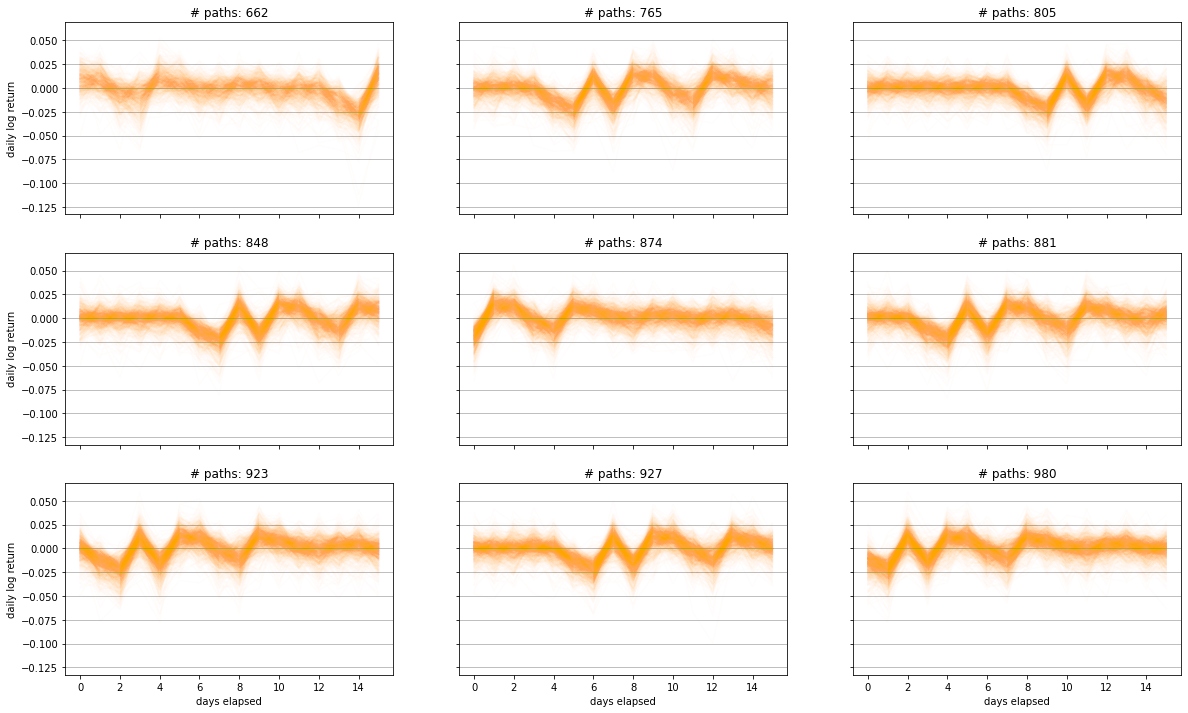

In [10]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, total_freq, 0.01, small_bins);

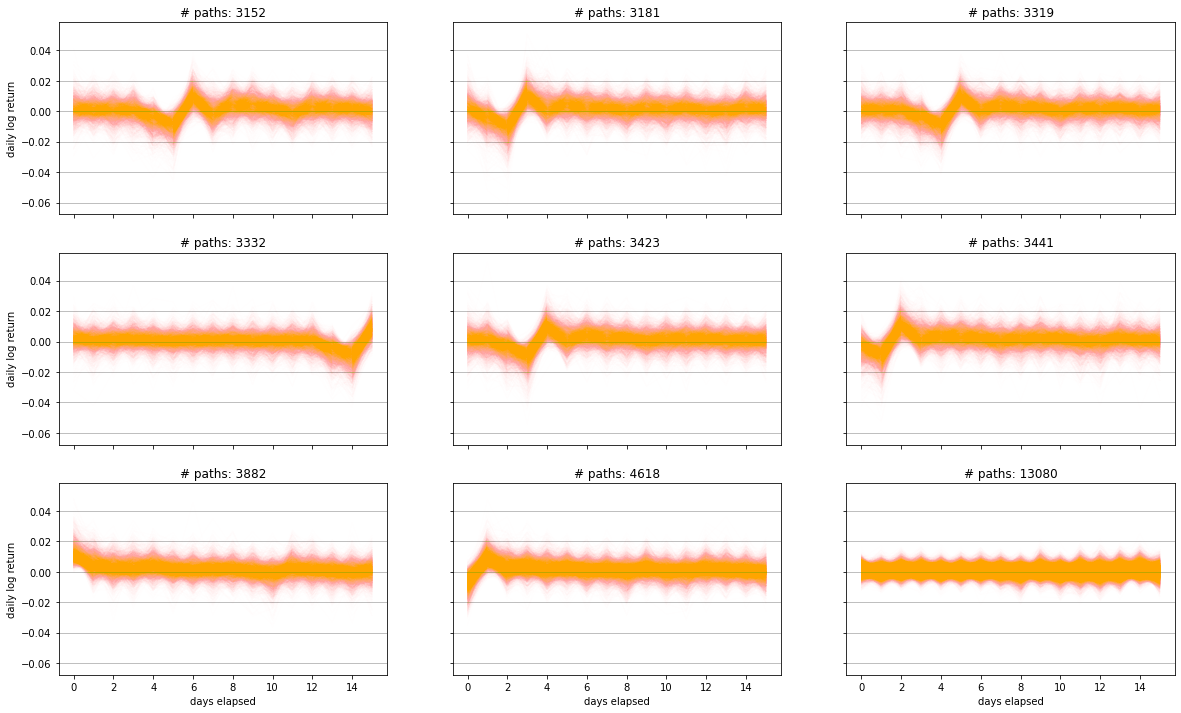

In [11]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, total_freq, 0.003, big_bins);

In [12]:
real_samples, synth_samples, real_bins, synth_bins, total_freq = clustering(real_returns, synth_returns, 127, 30)

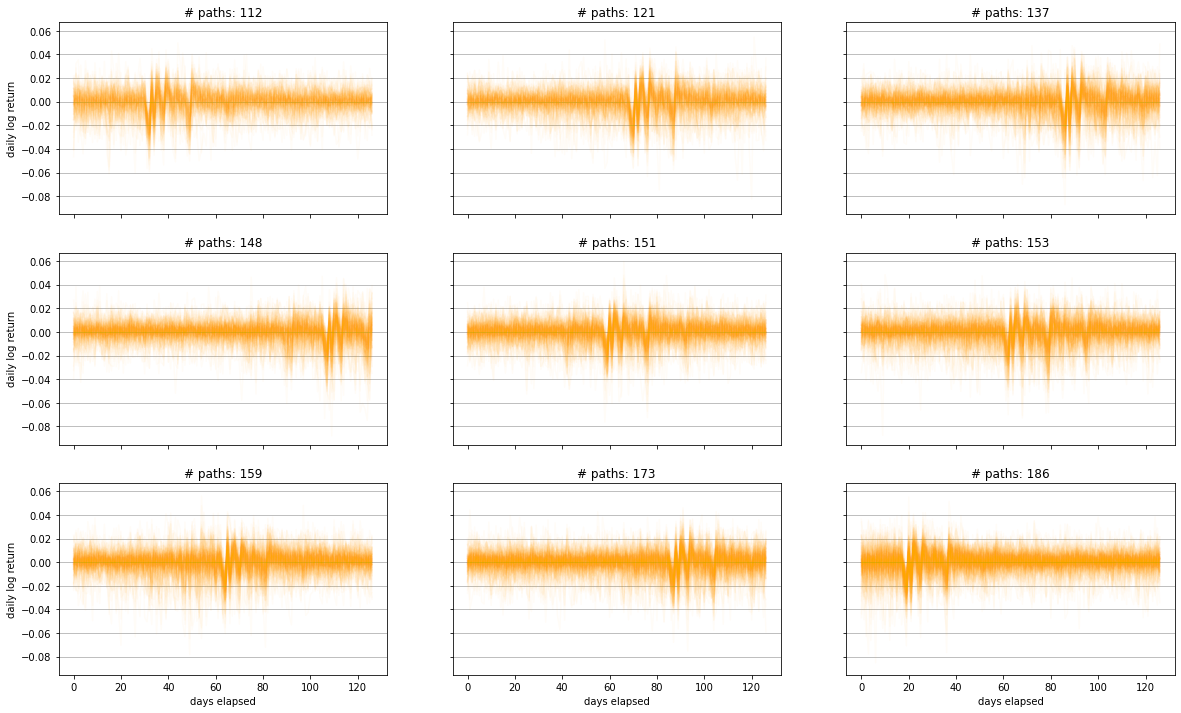

In [13]:
small_bins = np.argsort(total_freq[:, 1])[:9]
fig, ax = plot_clustering(synth_samples, synth_bins, total_freq, 0.03, small_bins);

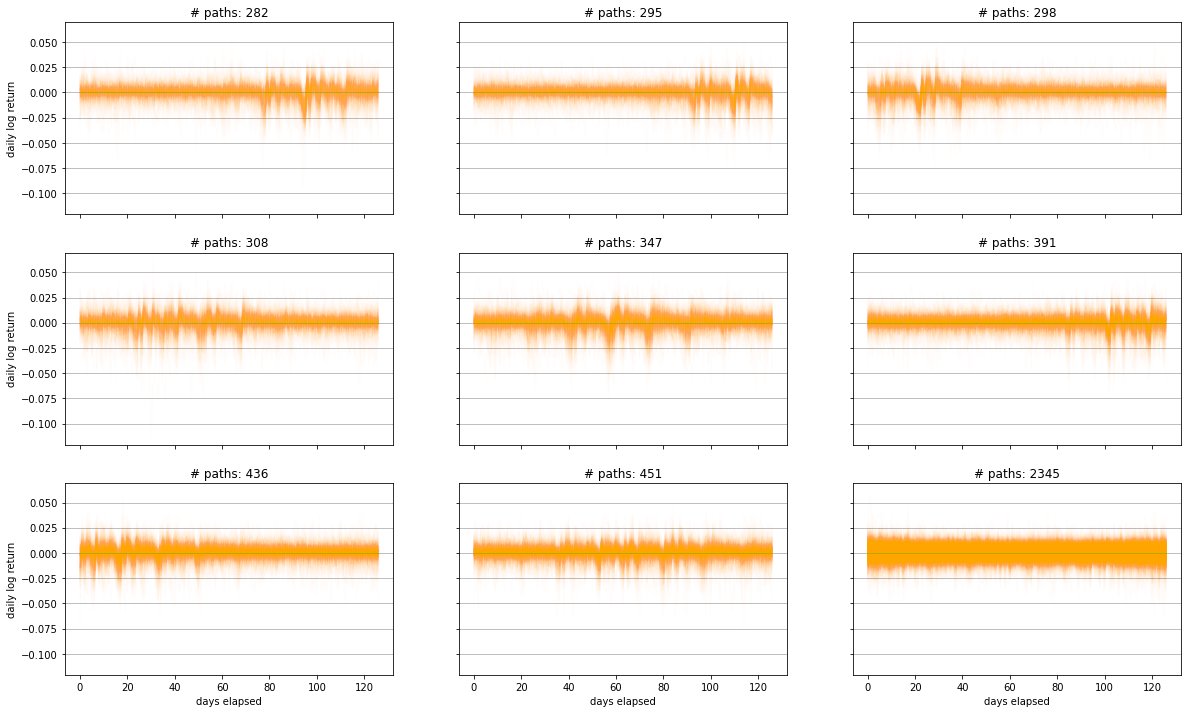

In [14]:
big_bins = np.argsort(total_freq[:, 1])[-9:]
fig, ax = plot_clustering(synth_samples, synth_bins, total_freq, 0.01, big_bins);

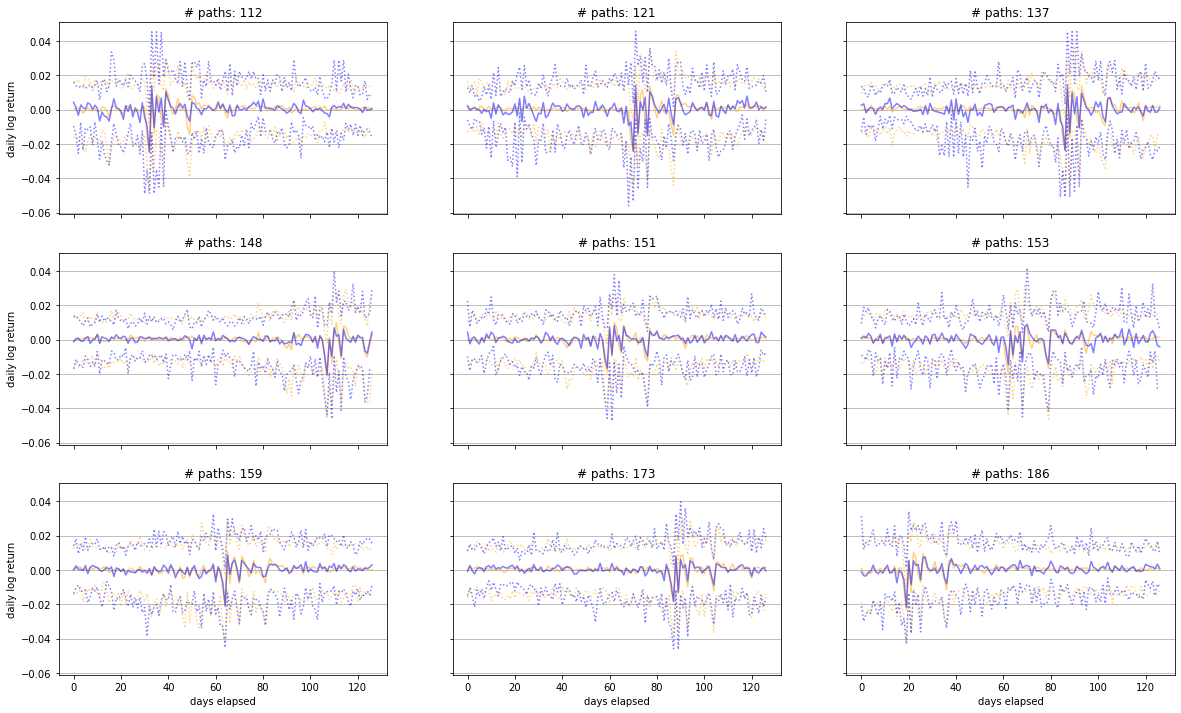

In [15]:
fig, ax = plt.subplots(figsize=(20,12), nrows=3, ncols=3, squeeze=False, sharex=True, sharey=True)

i = 0
j = 0
for bin in small_bins:
    ax[i, j].plot(synth_samples[synth_bins == bin].mean(axis=0), color='orange', alpha=0.5);
    ax[i, j].plot(np.moveaxis(np.quantile(synth_samples[synth_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='orange', linestyle='dotted', alpha=.5)
    ax[i, j].set_title('# paths: {}'.format(int((synth_bins == bin).sum())))
    ax[i, j].grid(axis='y', which='major')

    if (real_bins == bin).sum() > 0:
        ax[i, j].plot(real_samples[real_bins == bin].mean(axis=0), color='blue', alpha=0.5)
        ax[i, j].plot(np.moveaxis(np.quantile(real_samples[real_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='blue', linestyle='dotted', alpha=.5)
    j += 1
    j = j % 3
    if j == 0:
        i += 1
        
plt.setp(ax[-1, :], xlabel='days elapsed')
plt.setp(ax[:, 0], ylabel='daily log return');

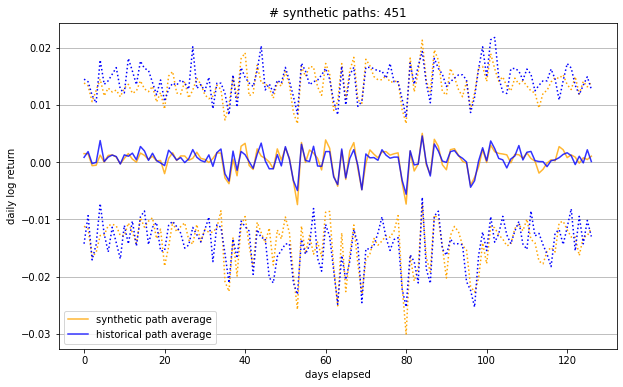

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

bin=7

ax.plot(synth_samples[synth_bins == bin].mean(axis=0), color='orange', alpha=0.8, label='synthetic path average');
ax.plot(np.moveaxis(np.quantile(synth_samples[synth_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='orange', linestyle='dotted')
ax.set_title('# synthetic paths: {}'.format(int((synth_bins == bin).sum())))
ax.grid(axis='y', which='major')

ax.plot(real_samples[real_bins == bin].mean(axis=0), color='blue', alpha=0.8, label='historical path average')
ax.plot(np.moveaxis(np.quantile(real_samples[real_bins == bin], [0.05, 0.95], axis=0), 0, -1), color='blue', linestyle='dotted')
    

ax.legend();
ax.set_xlabel('days elapsed')
ax.set_ylabel('daily log return');